# Lightweight Transformer-based Optical Character Recognition 
(https://hal.science/hal-03685976/file/A_Light_Transformer_Based_Architecture_for_Handwritten_Text_Recognition.pdf)

## ***note: Has a CNN backbone***

-----------

## Architecture  
Build up with a double Transformer architecture:  
- Image transformer as encoder: Extracts the visual features
- Text transformer as decoder: Language modeling
- Encoder: 
- Decoder: Generates word-sections sequence using visual features and previous predictions

### Encoder:  

### Decoder: 

--------------


## Start pipeline

In [84]:
import os
from collections import OrderedDict

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision as tv

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

### Constants

In [85]:
DATA_PATH = f"/home/hkolstee/uniprojects/DATA/HWR/IAM-data/IAM-data/"
TRAIN_TEST_SPLIT = 0.2
BATCH_SIZE = 64
INPUT_HEIGHT = 128
# input width -> largest width in batch
# padded to get to width

### Prepare Data

In [86]:
raw_data = pd.read_fwf(DATA_PATH + "iam_lines_gt.txt", header = None)
raw_data = raw_data.values.tolist()

data = {'img_names': np.squeeze(raw_data[::2]),
        'labels': np.squeeze(raw_data[1::2])}

data = pd.DataFrame(data)
data

,img_names,labels
0,a03-017-07.png,into the pro-communist north and the
1,a03-017-05.png,"to 1958 kept the kingdom in peace, though"
2,a03-017-08.png,pro-western centre and south.
3,a03-017-02.png,in Phnom Penh indicate that he still regards
4,a03-017-06.png,at the cost of virtual partition of the country
...,...,...
7453,d06-000-08.png,fears are based upon completely
7454,d06-000-05.png,"is worrying them, to find the original"
7455,d06-000-09.png,irrational pre-conceived notions - or to
7456,d06-000-02.png,"already suggested, not to be silly or"


### TODO: Data augmentation

### Train test split

In [87]:
train, test = train_test_split(data, test_size = TRAIN_TEST_SPLIT)

# reset indices from current random state
train.reset_index(inplace = True)
test.reset_index(inplace = True)

### Create custom pytorch dataset

first, we need the input/image width we have to resize the images to.  
This is the largest image width in the entire batch of images (source paper randomly added/removed new augments each training epoch).   
For now we just take the largest width in the original images.

In [ ]:
def getBiggestWidth(data: pd.DataFrame):
    biggest_width = 0

    for index in range(len(data['img_names'])):
        image_path = os.path.join(DATA_PATH, "img", data['img_names'][index])
        image = read_image(image_path)
        
        if (image.size(2) > biggest_width):
            biggest_width = image.size(2)

    return biggest_width

In [100]:
input_width = getBiggestWidth(data)
print(input_width)

1628
1761
1188
1699
1803
1784
1819
1808
1753
1914
1829
1863
1957
1867
1797
1675
1698
1730
1609
1696
1573
1598
1625
1765
1732
1401
1715
1864
1848
1928
1854
1217
2003
1925
1913
1782
1763
1961
1810
1768
1625
1822
1602
767
1757
1865
1723
1869
1610
1800
1865
1786
1693
1830
1739
1862
1759
1703
1802
1861
1827
1844
977
1672
1712
1774
1891
1849
1904
1803
1921
1664
1728
1754
1813
1798
1246
1812
1832
1605
1814
1812
1725
1956
1962
1790
1674
1372
1895
1743
1959
1725
1800
1958
1867
2035
1649
1536
1716
1707
985
1972
1854
1781
1646
1865
1904
1682
1748
1356
1704
1791
1668
1700
1953
1658
1891
1828
1824
961
1911
1875
1796
1760
1720
1749
1724
1804
1423
1718
589
1591
1543
1739
1823
1738
1714
1808
1749
1573
1638
1810
1613
1751
2043
1911
1826
2020
1859
1952
1925
1721
2098
1821
1410
1657
1881
1898
1811
1477
1692
1827
1600
1850
1815
1527
1876
895
1808
1590
1820
1845
1670
1911
1869
1754
733
1739
1897
1775
1782
1733
1838
310
1679
1737
1746
1882
1773
1822
1824
1742
1871
1836
1987
610
1883
1612
1931
1843
1726
1800

In [89]:
class HandWritingDataset(Dataset):
    def __init__(self, data: pd.DataFrame, img_width, img_height, batch_size):
        self.data = data
        self.batch_size = batch_size

    # function to get patches of tokens from original input image
    # def __getTokens__(self, image):
        # pass

    def __getitem__(self, index):
        # input image
        image_path = os.path.join(DATA_PATH, "img", self.data['img_names'][index])
        # torchvision read_image call
        image = read_image(image_path)
        # resize to 
        
        
        # string label
        label = self.data['labels'][index]

        return image, label

    def __len__(self):
        # return length of column
        return len(self.data)

In [90]:
input_width = 10
train_set = HandWritingDataset(train, input_width, INPUT_HEIGHT, BATCH_SIZE)
test_set = HandWritingDataset(test, input_width, INPUT_HEIGHT, BATCH_SIZE)

### Model

Sinusodial positional encoding

In [91]:
class SinPosEncoding(nn.Module):
    def __init__(self, dimensionality):
        super(SinPosEncoding, self).__init__()
        self.dims = dimensionality
        self.max_len = 5000

        # position vector
        positions = torch.arange(0, self.max_len).unsqueeze(1)
        # calculate added angle for sin/cos
        angle = torch.exp(torch.arange(0, self.dims, 2) * (-np.log(10000.0) / self.dims))

        # initialize the 2D positional encodings array
        pos_encodings = torch.zeros(self.max_len, 1, self.dims)
        # calucalte encodings
        pos_encodings = torch.sin(positions * angle)

        # add to buffer for training performance (?)
        self.register_buffer('pos_encodings', pos_encodings)

    
    def forward(self, input: torch.Tensor):
        # adds the positional encoding elementwise to the tensor (seqlength, batch, embeddims)
        input += self.pos_encodings[0:input.size(0)]

        return input

Model

In [92]:
class OCRTransformer(nn.Module):
    def __init__(self, input_width, input_height):
        super(OCRTransformer, self).__init__()

        # convolutional block (5 convolutions)
        # first convolution
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 8, kernel_size = (3,3))
        width = input_width - 2
        height = input_height - 2
        self.leakyRelu = nn.LeakyReLU()     # reuse in later layers
        self.layerNorm1 = nn.LayerNorm(normalized_shape = [8, width, height])
        self.maxPool = nn.MaxPool2d((2,2))  # reuse in later layers
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))
        self.dropout = nn.Dropout(0.2)      # reuse in later layers

        # second convolutional layer
        self.conv2 = nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = (3, 3))
        width -= 2
        height -= 2
        self.layerNorm2 = nn.LayerNorm(normalized_shape = [16, width, height])
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))

        # third convolutional layer
        self.conv3 = nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = (3, 3))
        width -= 2
        height -= 2
        self.layerNorm3 = nn.LayerNorm(normalized_shape = [32, width, height])
        # after maxpool
        width = int(np.floor(width/2))
        height = int(np.floor(height/2))

        # forth convolutional layer
        self.conv4 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3, 3))
        width -= 2
        height -= 2
        self.layerNorm4 = nn.LayerNorm(normalized_shape = [64, width, height])
        # no maxpool

        # fifth convolutional layer (kernel size to better match shape of character)
        self.conv5 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (4, 2))
        width -= 1
        height -= 3
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, width, height])
        # no maxpool

        # following is convolution with width 1 which is used to flatten the current output
        self.flattenConv = nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size = (height, 1))
        self.layerNorm5 = nn.LayerNorm(normalized_shape = [128, width, 1])

        # dense layer to upscale from 128 to 256
        self.dense1 = nn.Linear(in_features = 128, out_features = 256)
        # sinusoidal positional encoding is added to the output of the dense layer
        self.pos_encoding = SinPosEncoding(256)

        # Here starts: transformer layers

    def forward(self, input):
        # through 5 convolutional layers
        # first conv
        out = self.layerNorm1(self.leakyRelu(self.conv1(input)))
        out = self.dropout(out)
        # second conv
        out = self.layerNorm2(self.leakyRelu(self.conv2(out)))
        out = self.dropout(out)
        # third conv
        out = self.layerNorm3(self.leakyRelu(self.conv3(out)))
        out = self.dropout(out)
        # forth conv
        out = self.layerNorm4(self.leakyRelu(self.conv4(out)))
        # fifth conv
        out = self.layerNorm5(self.leakyRelu(self.conv5(out)))

        # flatten layer
        out = self.layerNorm5(self.leakyRelu(self.flattenConv(out)))
        # dense layer (activation function not mentioned in paper)
        out = self.dense1(out)
        # add sinusodial positional information
        out = self.pos_encoding(out)

        return out

### Resize and pad images

In [93]:
# resizes to largest width in batch x 128, keeping aspect ratio and padding image
def resizeBatch(images):
    # get largest size
    pass

tensor(243.7332)


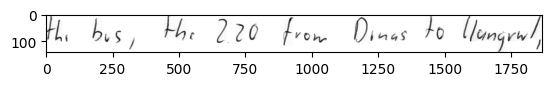

In [94]:
input_width = 2000
char_recog_transformer = OCRTransformer(input_width, INPUT_HEIGHT)

test_image, _ = train_set.__getitem__(1)
print(test_image.float().mean())
plt.imshow(test_image[0, :, :], cmap = "gray")

